<a href="https://colab.research.google.com/github/sebastianfernandezgarcia/YoloV7-CustomDetectionTutorial-TransferLearning-DetectAFireSmoke/blob/main/Training_YOLOv7_on_Custom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Descargamos Repositorio de YoloV7 e instalamos los requerimientos
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt

# Preparación de los datos.
Descargando e importando el dataset.
Los datos se encuentran estructurados de la siguiente manera:
- test
  - images
  - labels
-train
  - images
  - labels
-valid
  - images
  - labels
-data.yaml

Incluye 737 imágenes de incendios anotadas en Roboflow, una plataforma que facilita la etiquetación de datos con gran variedad de formatos

In [24]:
#Descargamos el dataset etiquetado para yoloV7, en este caso son imágenes de fuego

!curl -L "https://public.roboflow.com/ds/fn33ay1jzf?key=hzlJELNXXy" > fuego.zip
!unzip fuego.zip
!rm fuego.zip

# Traemos un fichero yaml modificado para que pueda funcionar en Google Colab (se modifica el directorio a donde se acceden los conjuntos de train y val)
!curl -L "https://raw.githubusercontent.com/sebastianfernandezgarcia/otsedom.github.io/main/data_fuego.yaml" > data_fuego.yaml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 27.1M  100 27.1M    0     0  90.3M      0 --:--:-- --:--:-- --:--:-- 90.3M
/bin/bash: /content/yolov7/prueba2: Is a directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    62  100    62    0     0   1291      0 --:--:-- --:--:-- --:--:--  1291


# Descarga de pesos iniciales para YoloV7
A partir de estos pesos, haremos transfer learnign para aprender a detectar los incencios.

In [ ]:
# Nos descargamos unos pesos iniciales de YoloV7 para proceder a hacer transfer learning posteriormente
%cd /content/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

# Iniciamos el entrenamiento

En nuestro caso, hemos entrenado con 50 iteraciones dando una precisión bastante buena.

El número de batch se establece en 14 porque en 16 hay momentos que dependiendo de la gráfica que nos asignen, no es suficiente.
En caso de que sea asignada una gráfica inferior y de fallo, probar a bajar el número de batches.

## Si hay error en loss.py... (se encuentra en la carperta utils)
Tras unas cuantas horas viendo que hacer, ocurría un error en el loss.py, parece ser que es un bug en la implementación o que simplemente, por naturaleza con pytorch, los datos tienen que moverse a la GPU para ser usados y tiene que estar todo en GPU o habrá problemas. Esto se soluciona añadiendo 2 simples líneas el ficheros de loss.py

## Qué hacer si falla
Tras la línea 685 de loss.py añadir:
# 
from_which_layer.append((torch.ones(size=(len(b),)) * i).to('cuda'))

Tras la línea 756 de loss.py añadir:
# 
fg_mask_inboxes = fg_mask_inboxes.to(torch.device('cuda'))


# No obstante, aquí lo arreglamos
Si no quieres cambiar esto a mano, ponemos esta celda que es un script para borrar el actual loss.py y traernos uno ya corregido.

In [26]:
%cd /content/yolov7/utils
!rm loss.py
!wget https://raw.githubusercontent.com/sebastianfernandezgarcia/otsedom.github.io/main/VC/P7/loss.py

/content/yolov7/utils
--2022-12-11 18:05:01--  https://raw.githubusercontent.com/sebastianfernandezgarcia/otsedom.github.io/main/VC/P7/loss.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75098 (73K) [text/plain]
Saving to: ‘loss.py’

loss.py             100%[===================>]  73.34K  --.-KB/s    in 0.01s   

2022-12-11 18:05:02 (5.49 MB/s) - ‘loss.py’ saved [75098/75098]



# Con esto comenzamos el entrenamiento. 

- Si no quieres esperar a que se complete, puedes bajar el número de epochs o...
  - Hemos facilitado unos pesos ya entrenados más adelante con el mejor resultado de este entrenamiento que tomó un par de horas.
- Si quieres ir a ver directamente los resultados, puedes ahorrarte la ejecución de la siguiente celda.

In [14]:
%cd /content/yolov7
!python train.py --batch 14 --epochs 50 --data /content/yolov7/data_fuego.yaml  --weights 'yolov7_training.pt' --device 0 


/content/yolov7
YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.13.0+cu116 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=14, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='/content/yolov7/data.yaml', device='0', entity=None, epochs=50, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.p5.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp8', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=14, upload_dataset=False, v5_metric=False, weights='yolov7_training.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, 

# Evaluación

Aquí tenemos dos caminos.


1.   Si has ejecutado el entrenamiento ahora mismo en tu google collab
2.   Si quieres cargar los pesos que ya entrenamos nosotros por ti

# 1) Acabo de terminar de entrenar ahora mismo en mi collab
Genial, dejamos la siguiente celda que cogerá los pesos locales de tu propio entorno de ejecución.

NOTAS: Si has hecho más de 1 ejecución es posible que tengas que cambiar donde pone exp por exp2...exp5... la más reciente que tengas.

In [ ]:
# Run evaluation
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.1 --source /content/yolov7/test/images #Cambiar la carpeta exp si hay alguna posterior


# 2) Quiero descargar los pesos que ya han sido entrenado con bastente tiempo y probar resultados
De acuerdo, primero, descargamos los pesos que han sido entrenados y los pondremos en una carpeta para tenerlos localizados. Posteriormente ejecutamos el detector pero con los pesos descargados

In [28]:
#Vamos a guardar los pesos en la carpeta general para tenerlos a mano 
%cd /content/yolov7
!wget https://github.com/sebastianfernandezgarcia/otsedom.github.io/raw/main/VC/P7/best_weights_fuego.pt

#Una vez bajados, podemos iniciar la deteccion con estos pesos que ya hemos entrenado con bastante tiempo
!python detect.py --weights /content/yolov7/best_weights_fuego.pt --conf 0.1 --source /content/yolov7/test/images 

/content/yolov7
--2022-12-11 18:23:03--  https://github.com/sebastianfernandezgarcia/otsedom.github.io/raw/main/VC/P7/best_weights_fuego.pt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sebastianfernandezgarcia/otsedom.github.io/main/VC/P7/best_weights_fuego.pt [following]
--2022-12-11 18:23:03--  https://raw.githubusercontent.com/sebastianfernandezgarcia/otsedom.github.io/main/VC/P7/best_weights_fuego.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74766031 (71M) [application/octet-stream]
Saving to: ‘best_weights_fuego.pt.1’

best_weights_fuego. 100%[===================>]  71.30M   215MB/

# Ver los resultados de la detección
Mostramos las imágenes que acaban de salir de la detección

Siempre las podremos ver en el propio directorio o también se añaden ejemplos: [Enlace a ver los ejemplos](https://github.com/sebastianfernandezgarcia/otsedom.github.io/tree/main/VC/P7/resultados
)


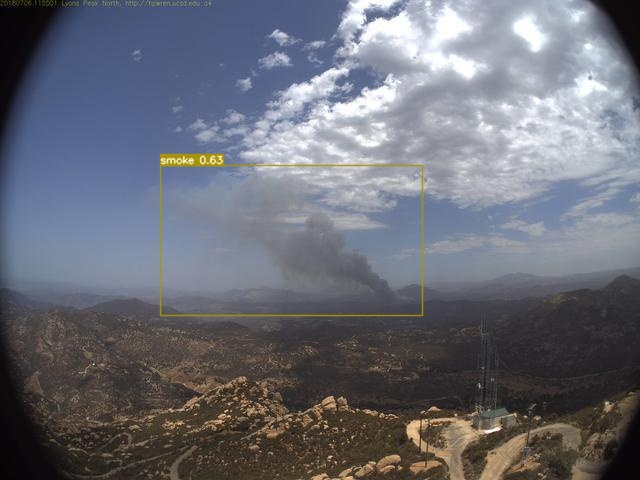

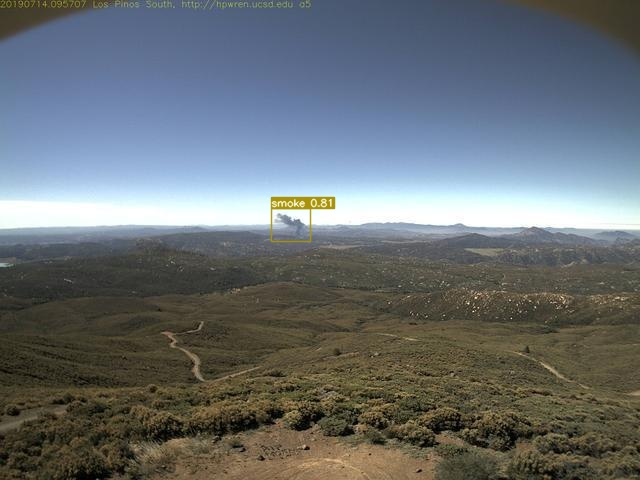

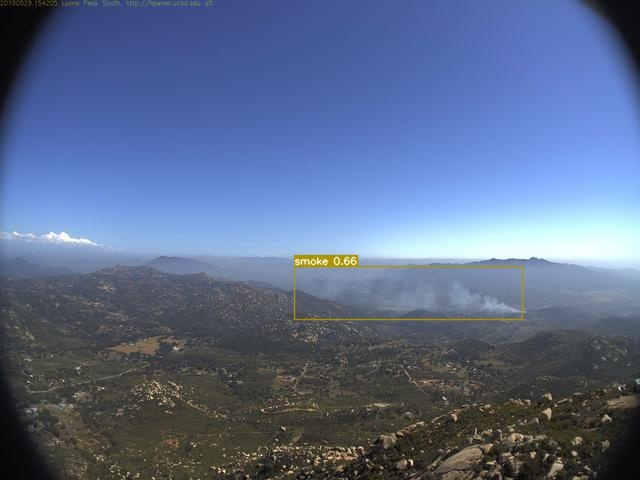

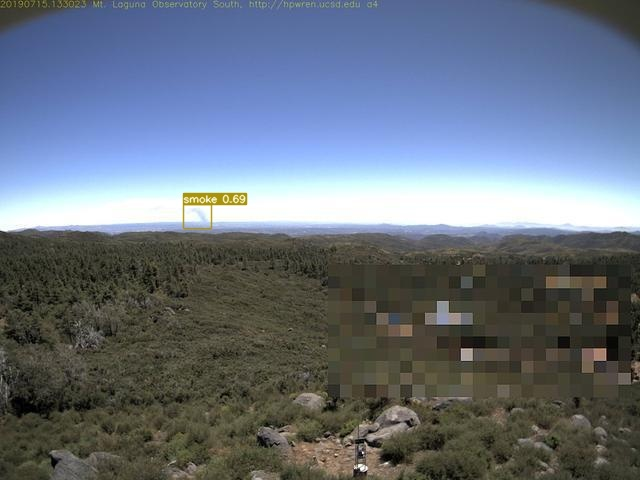

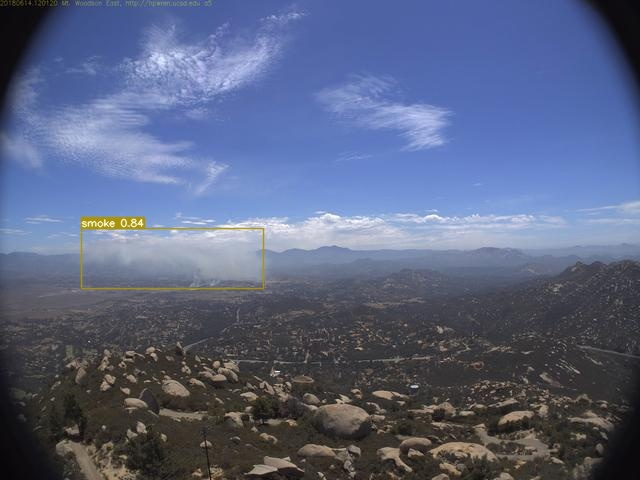

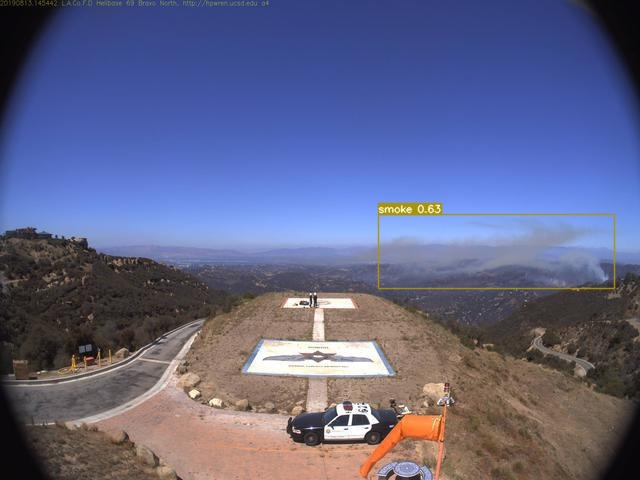

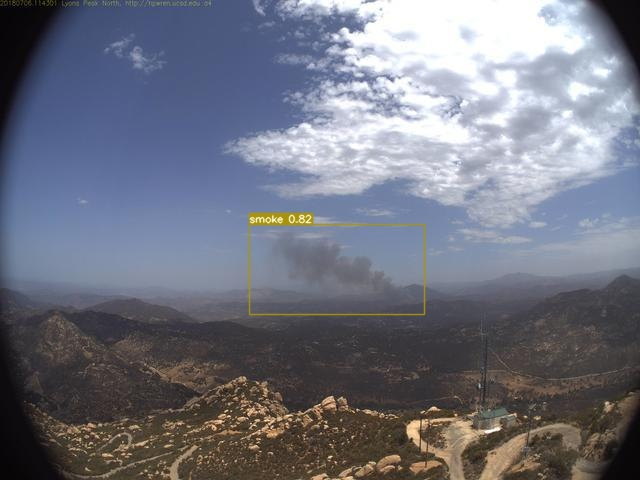

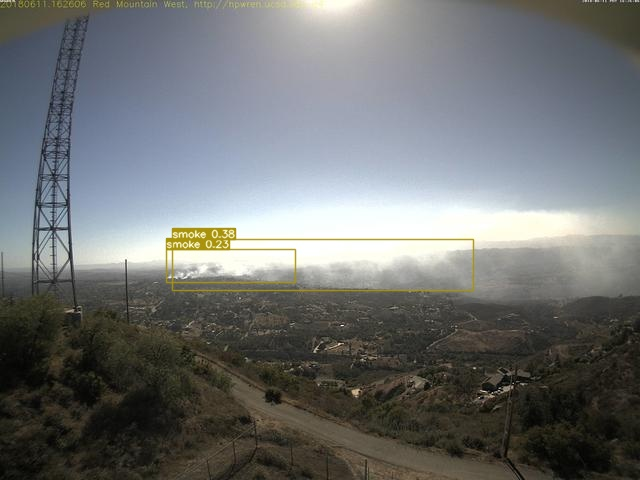

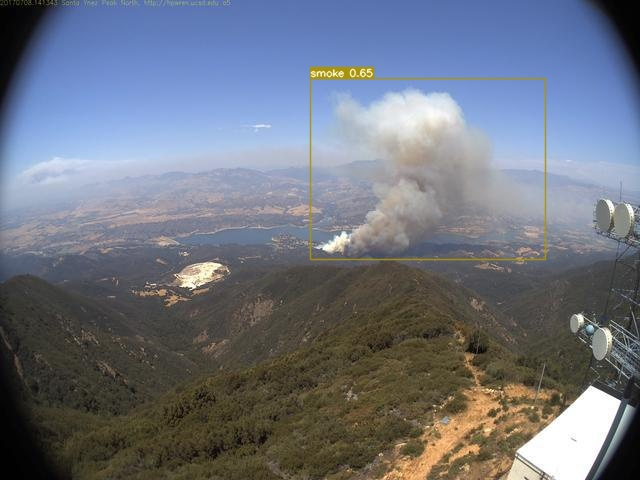

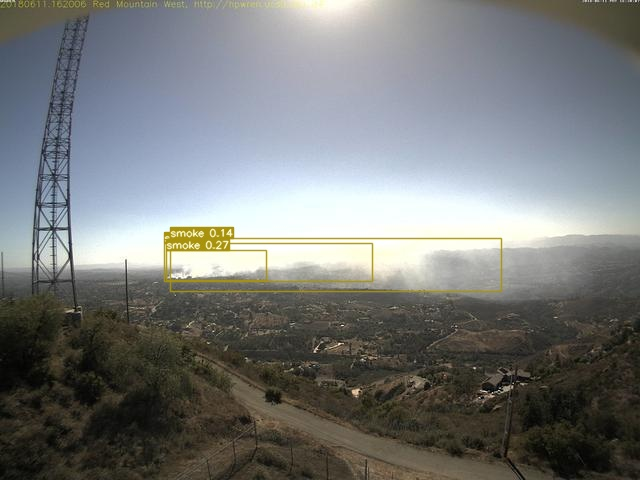

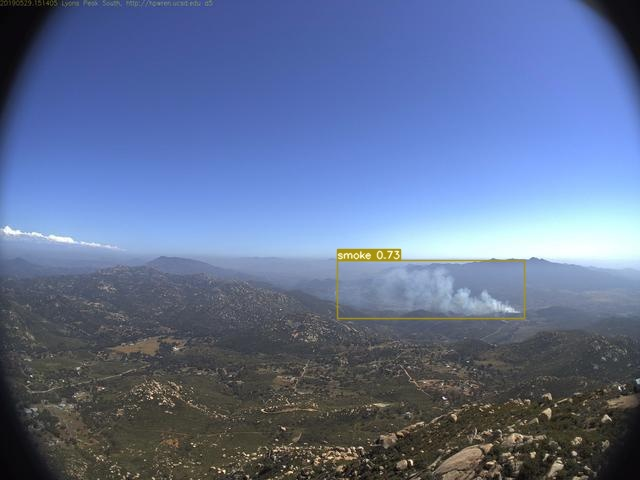

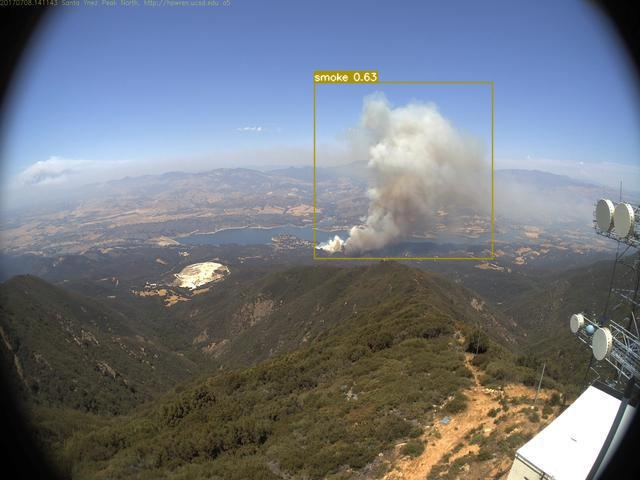

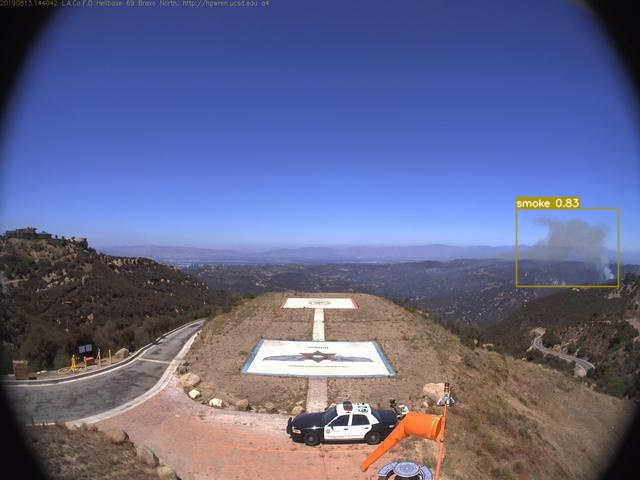

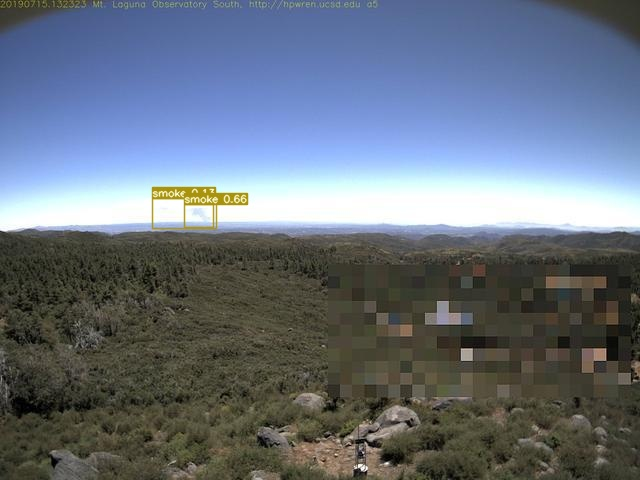

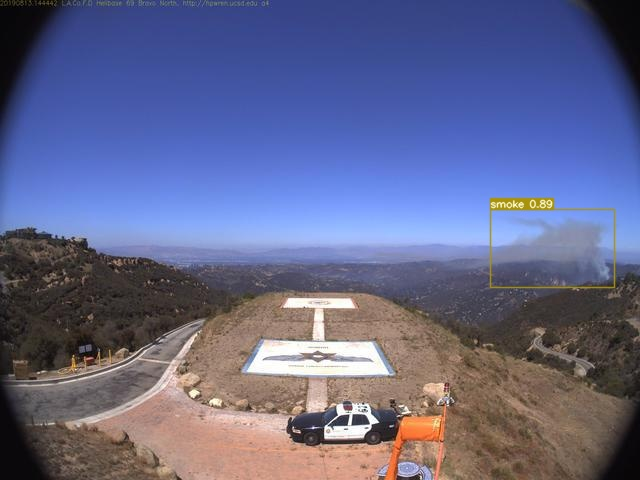

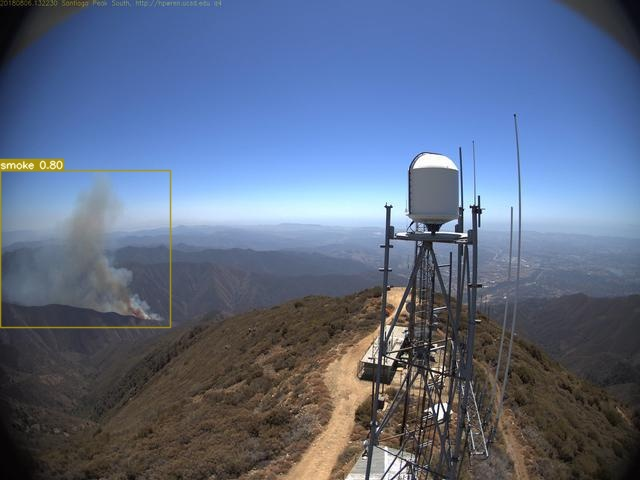

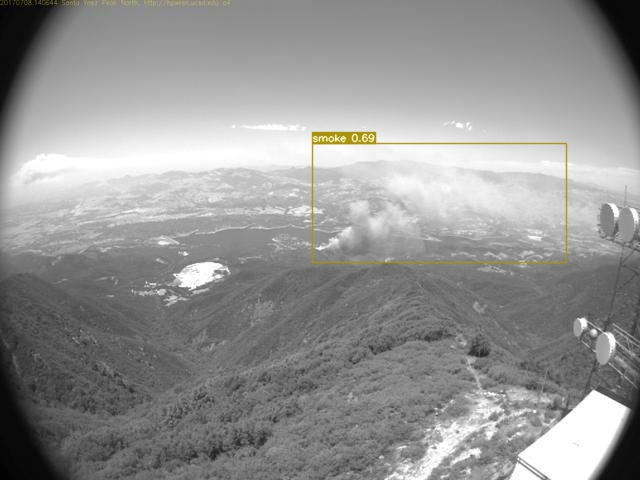

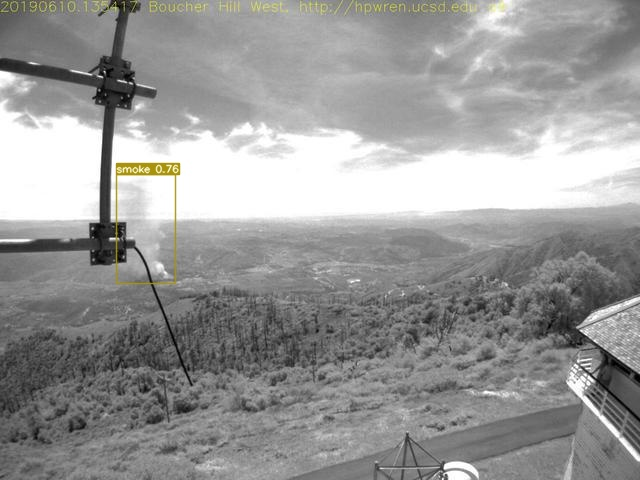

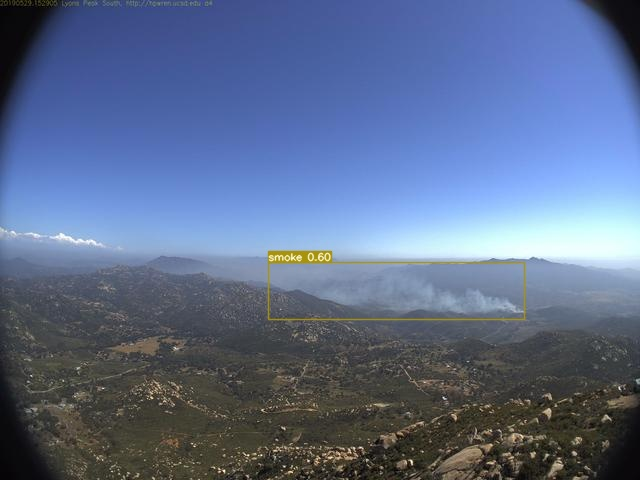

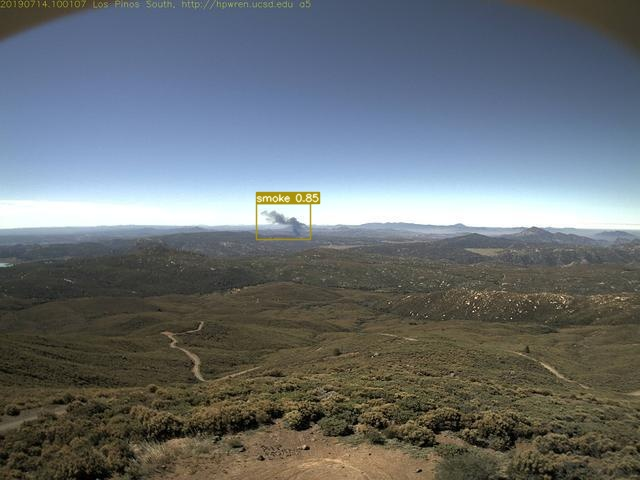

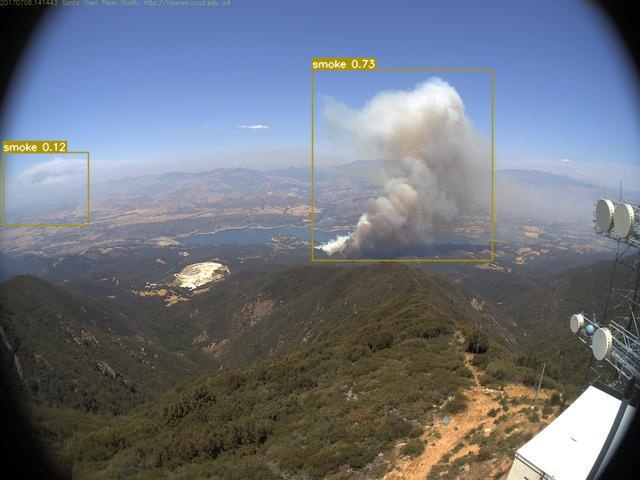

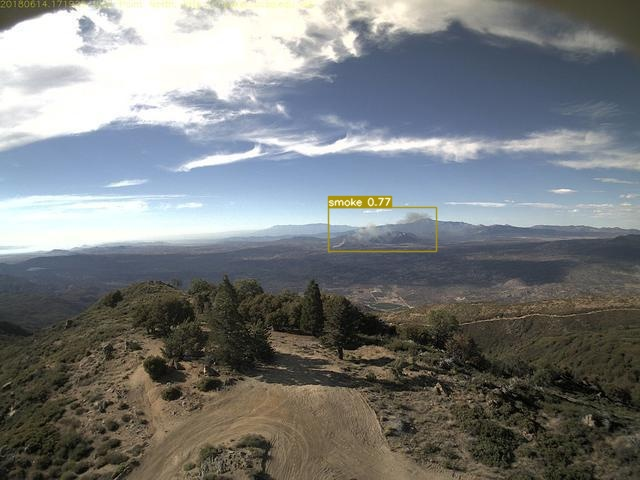

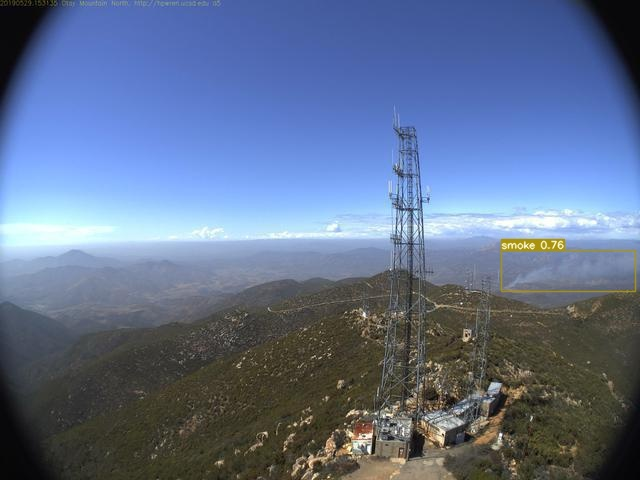

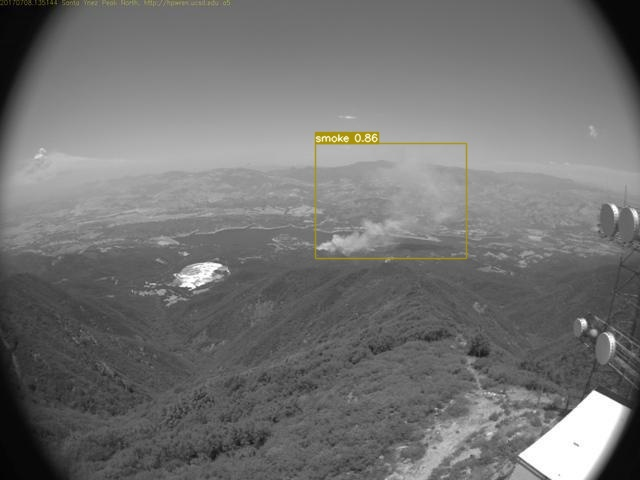

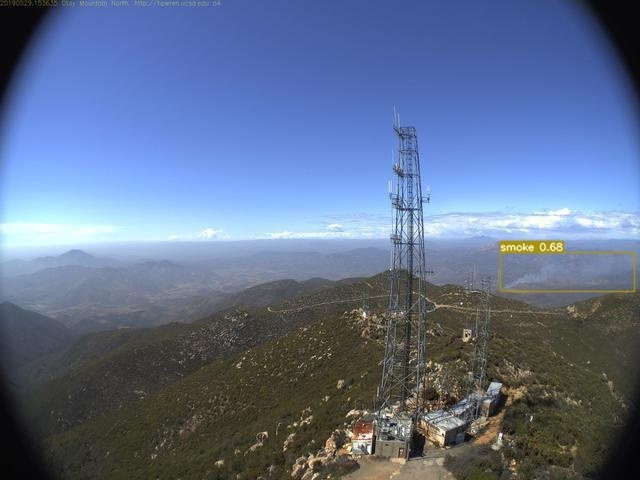

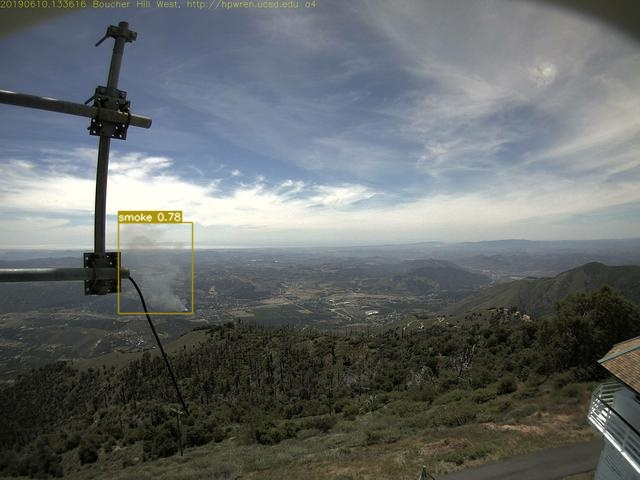

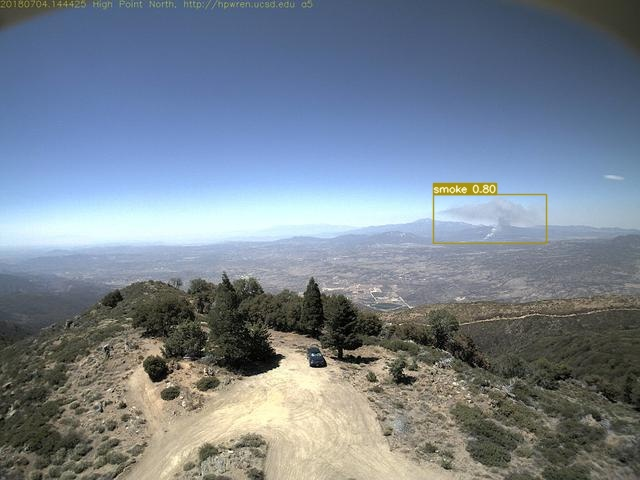

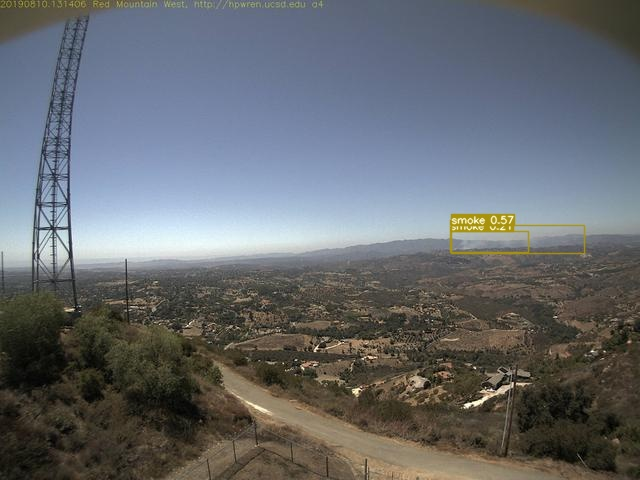

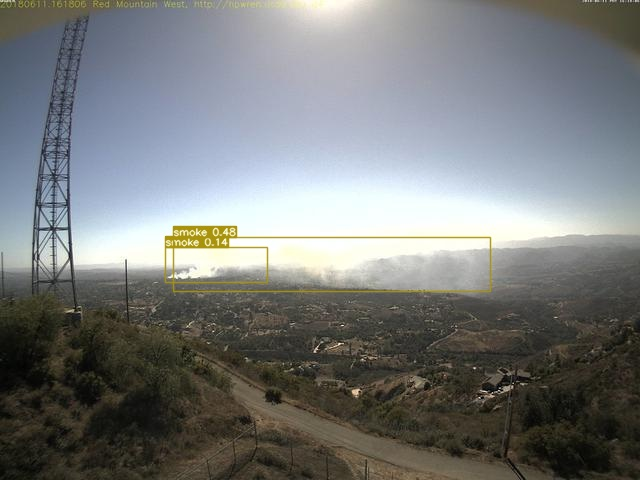

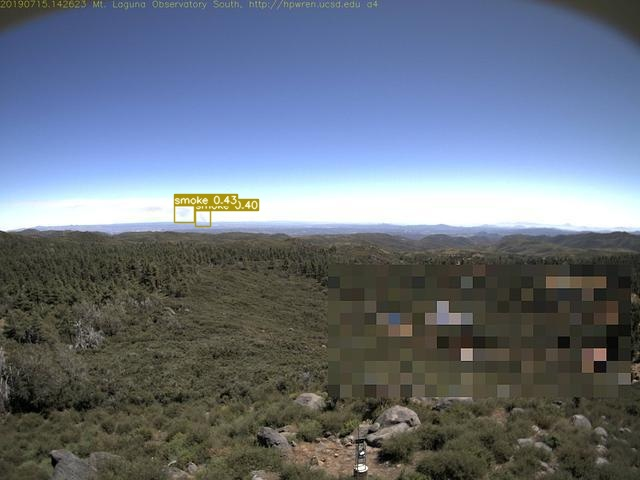

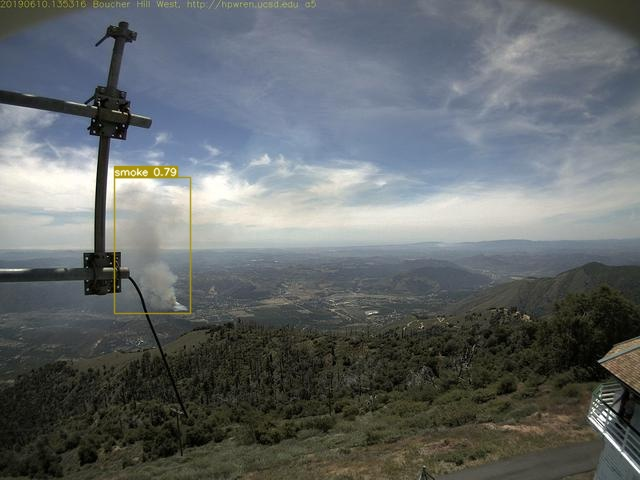

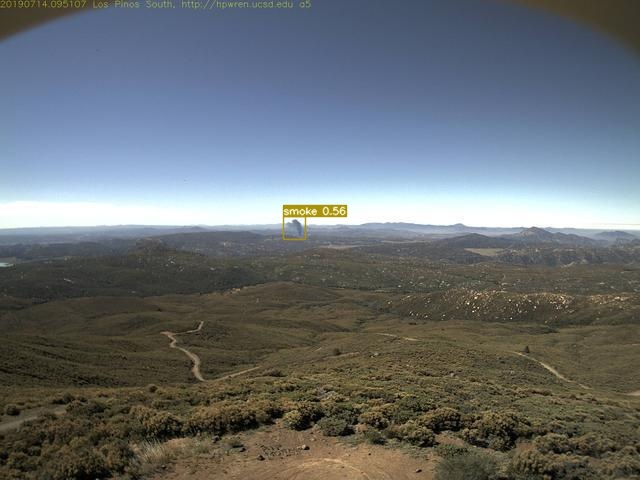

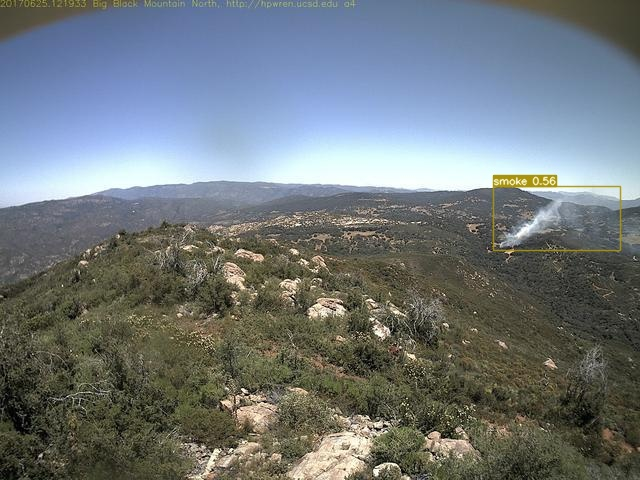

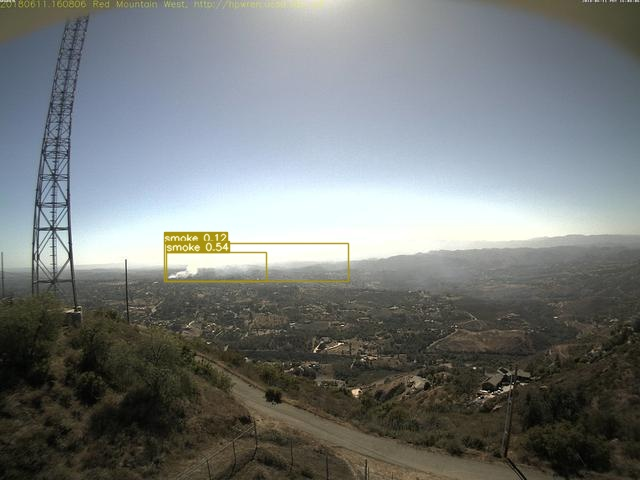

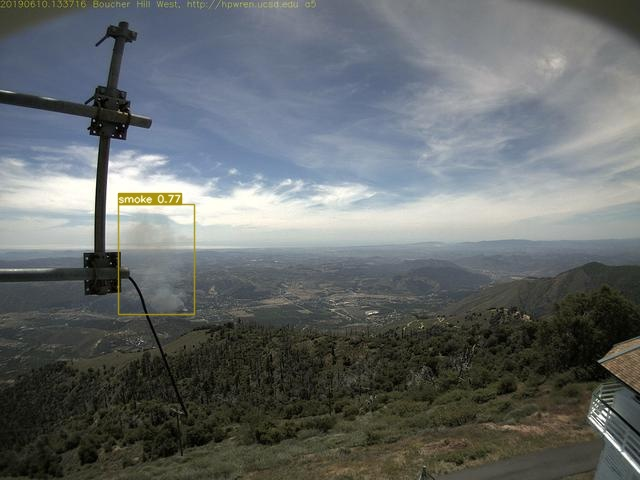

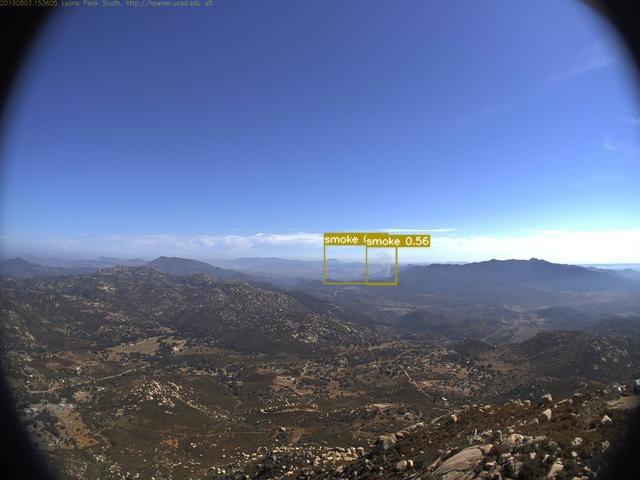

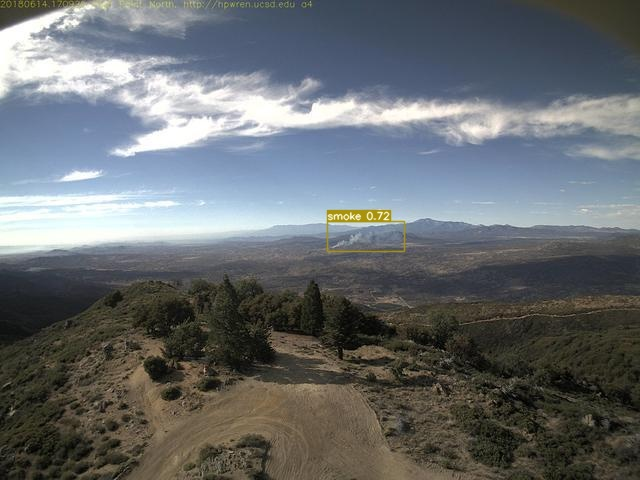

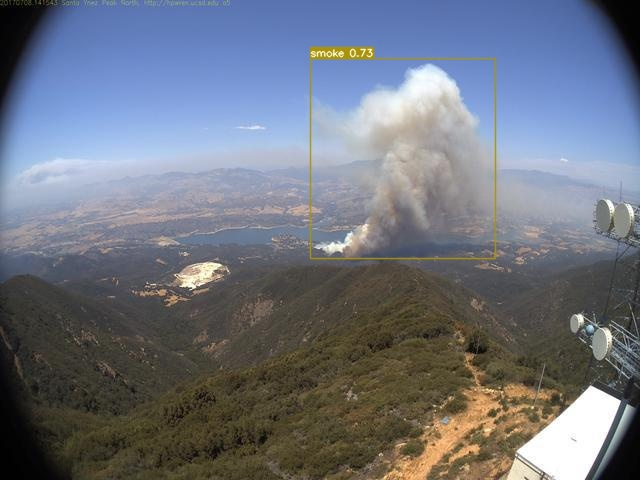

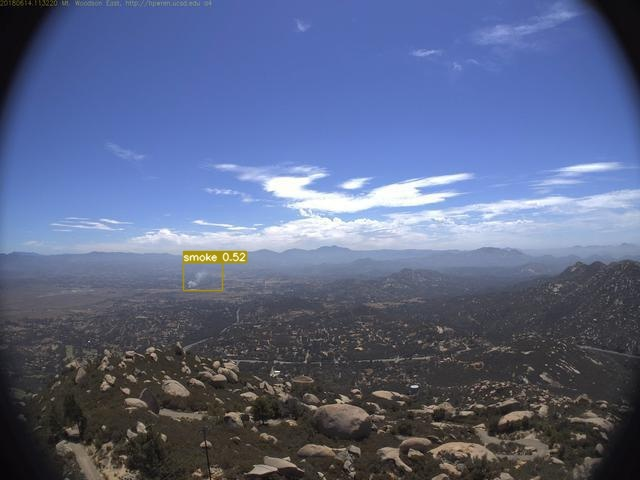

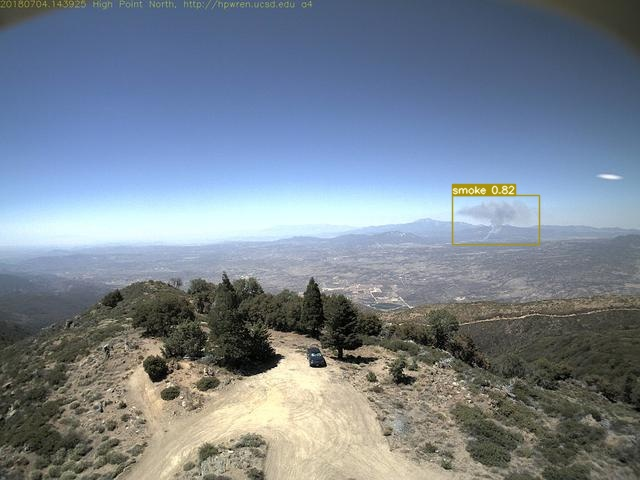

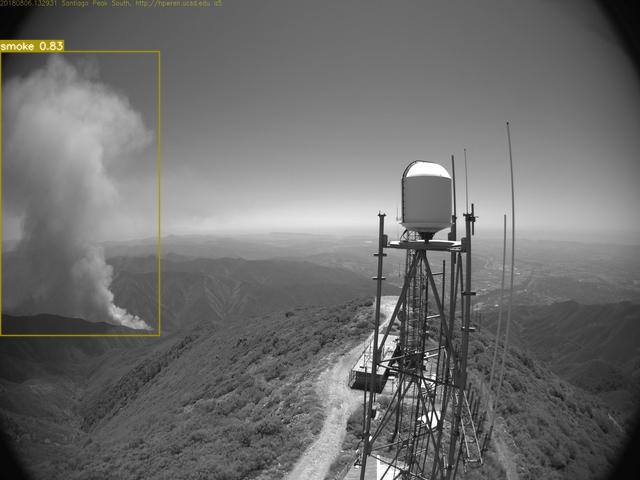

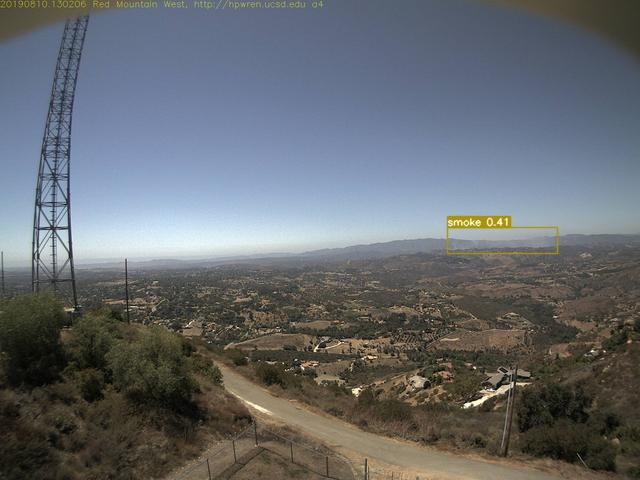

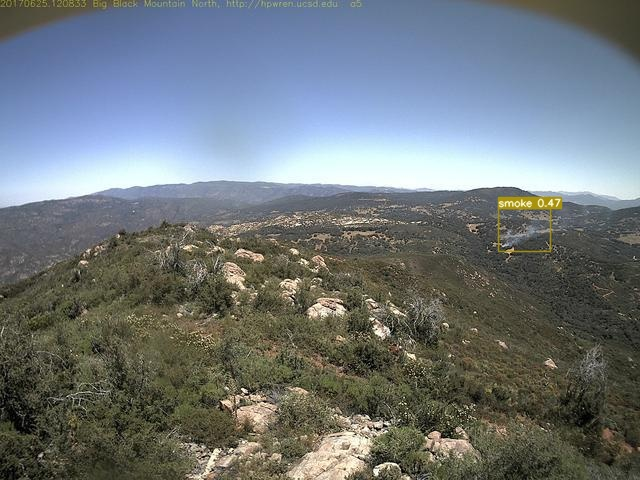

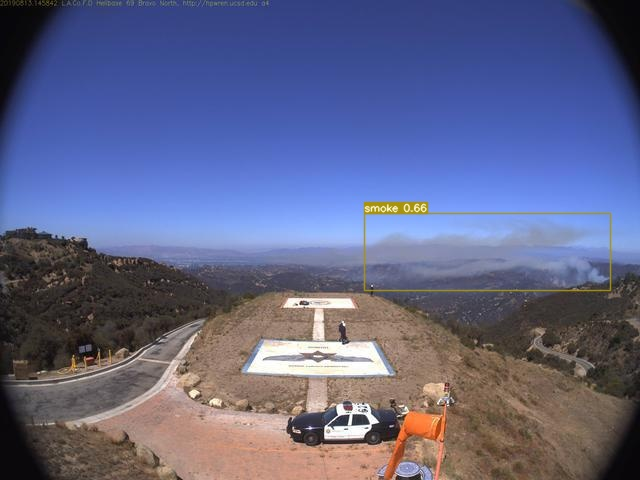

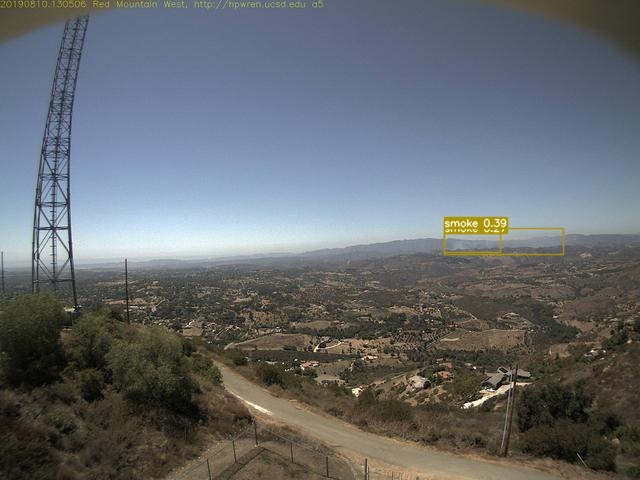

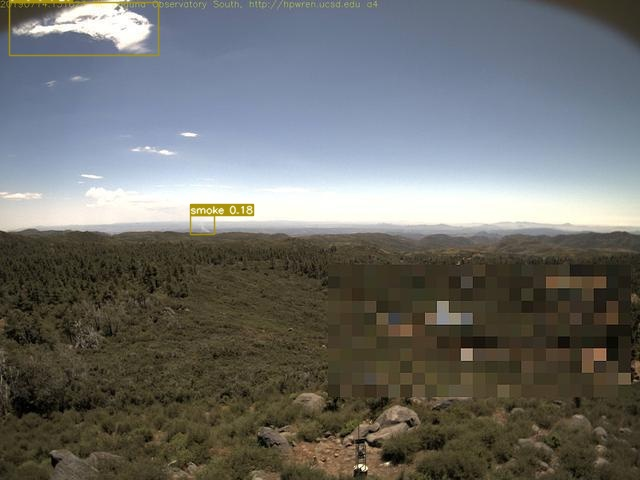

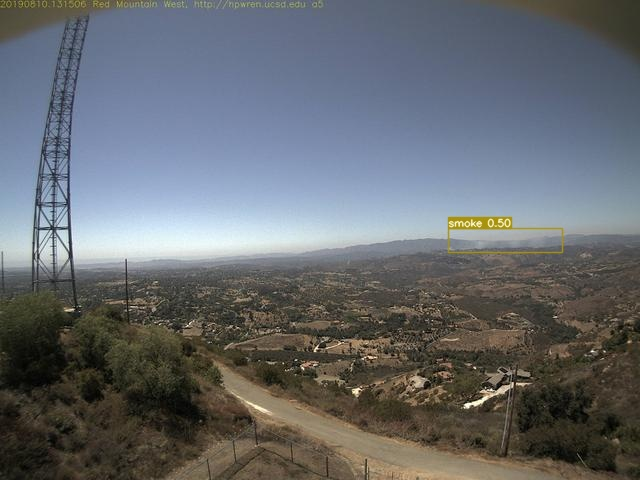

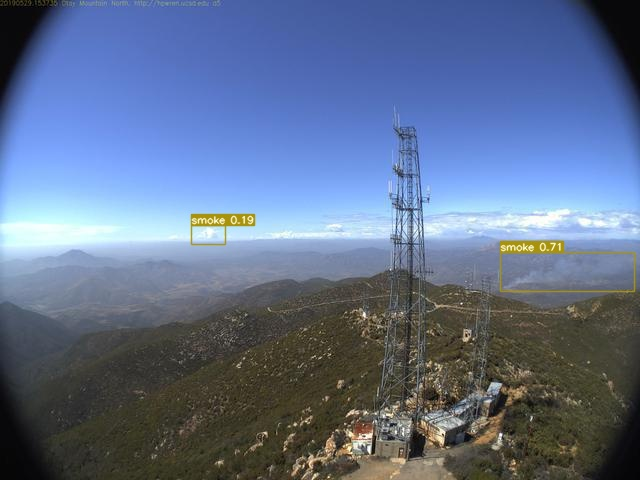

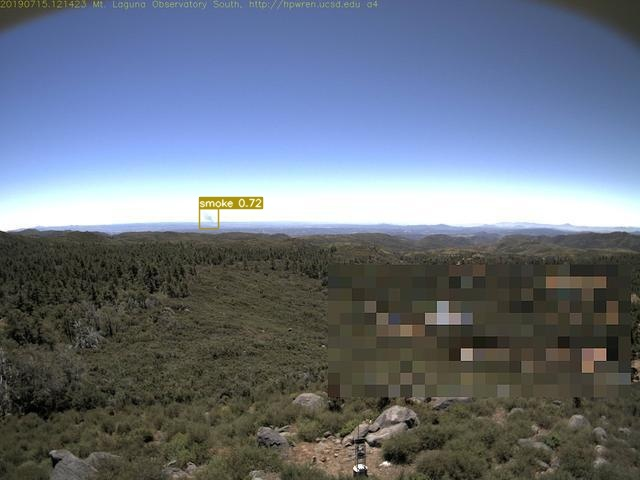

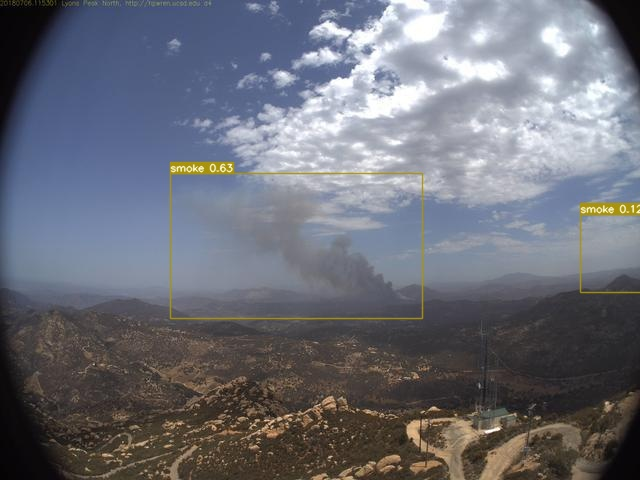

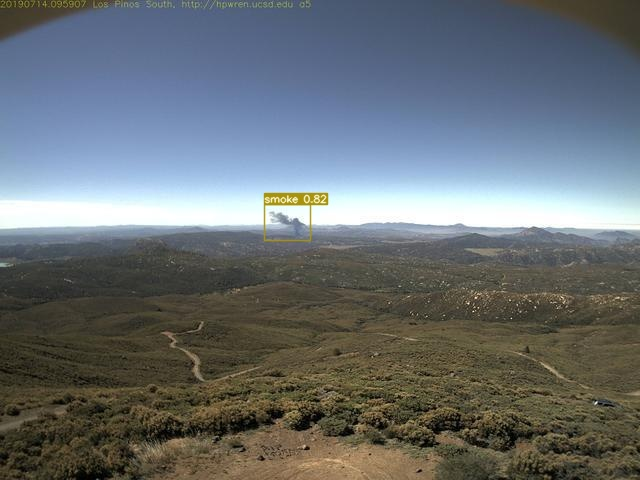

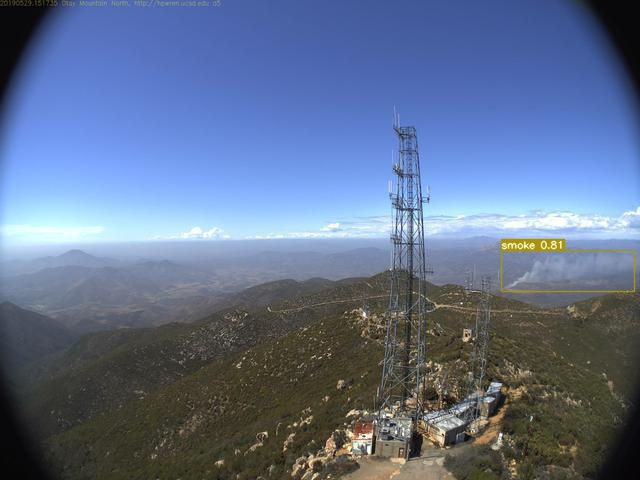

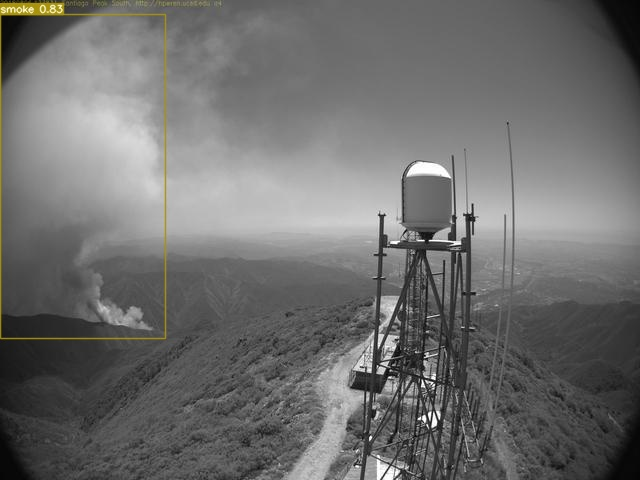

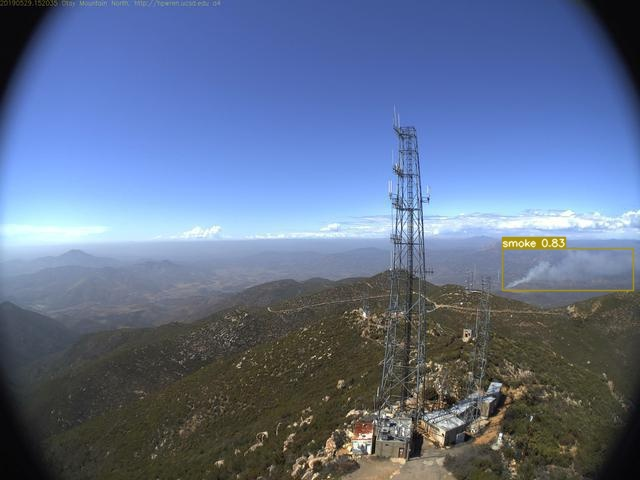

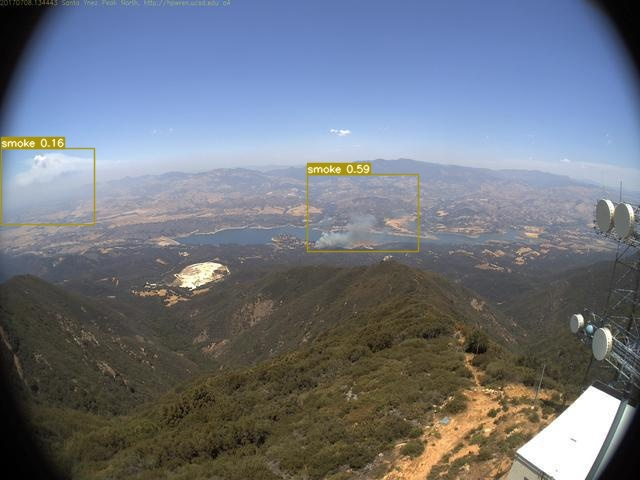

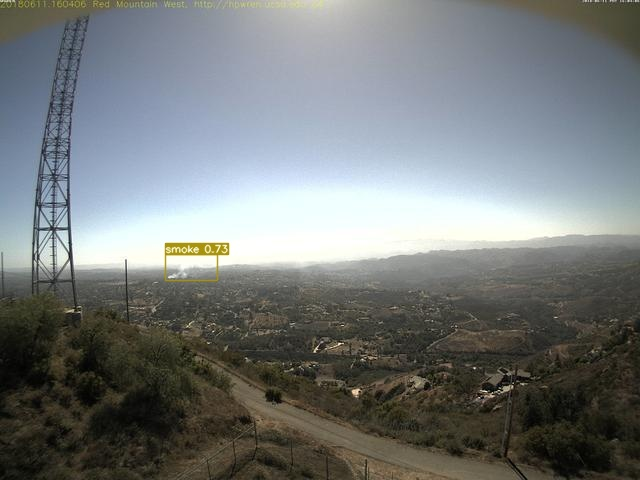

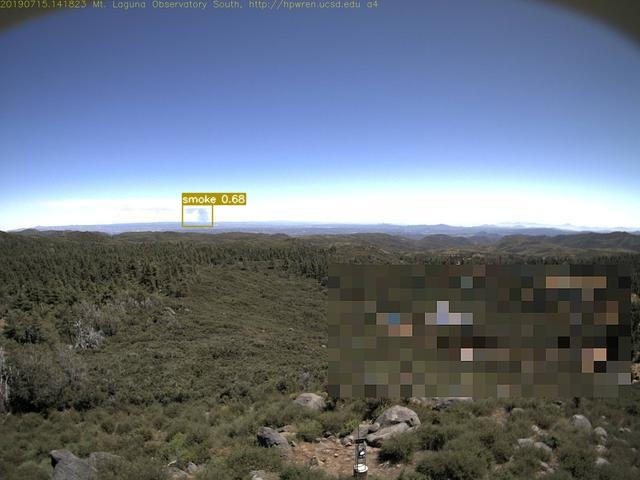

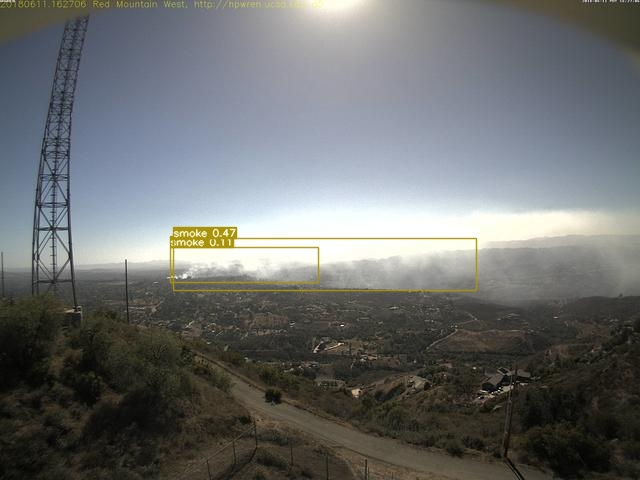

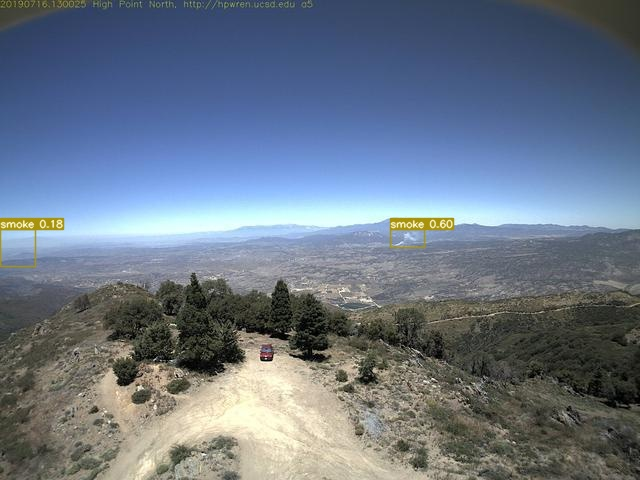

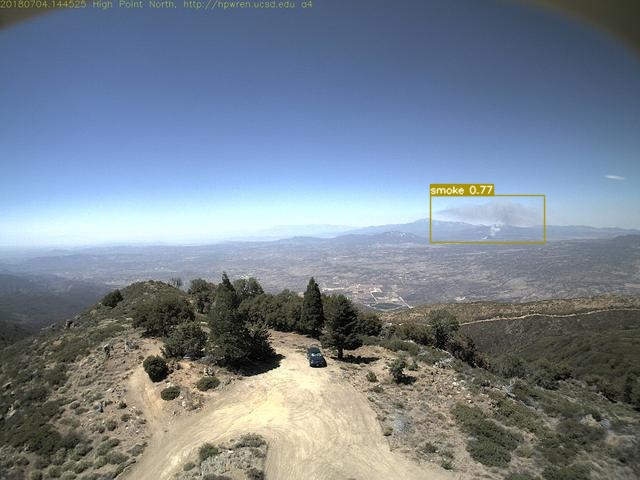

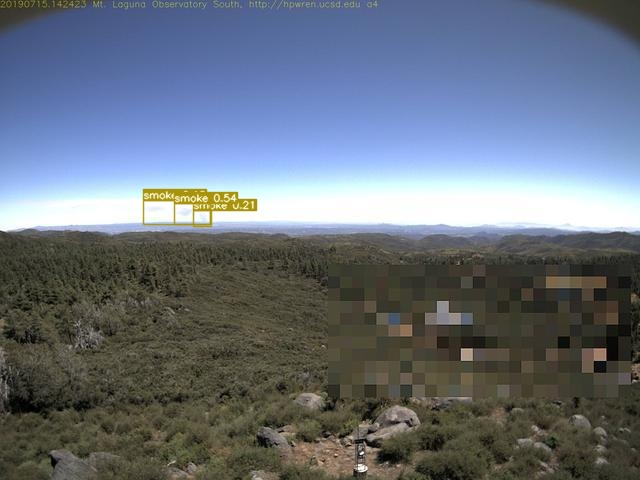

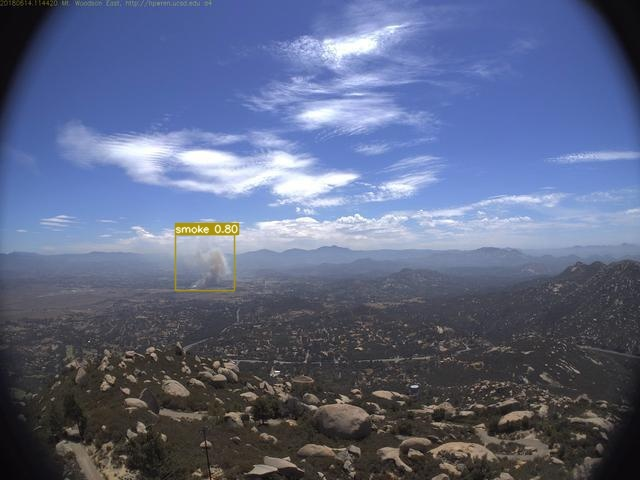

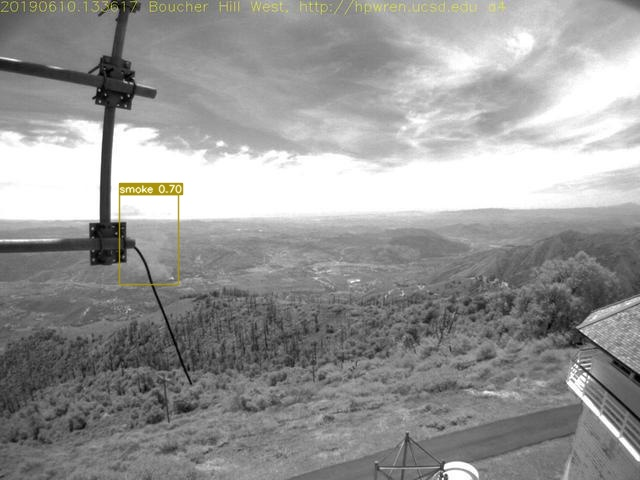

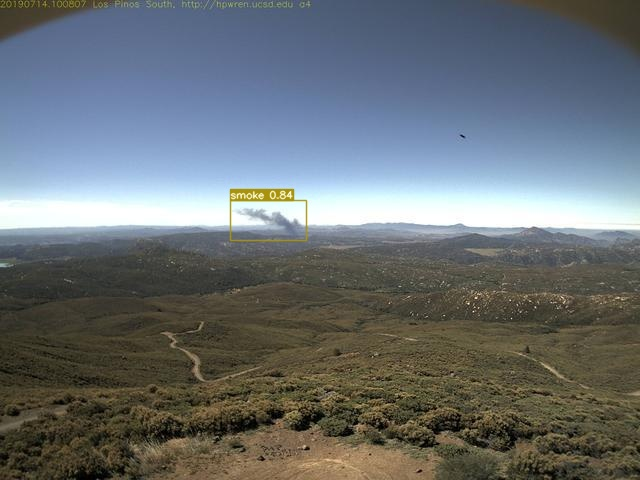

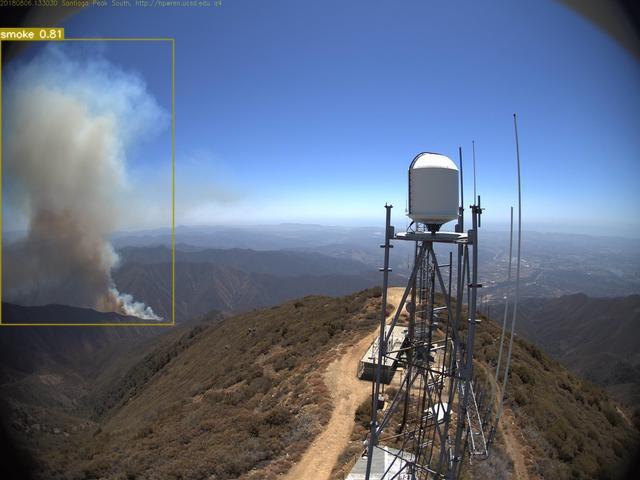

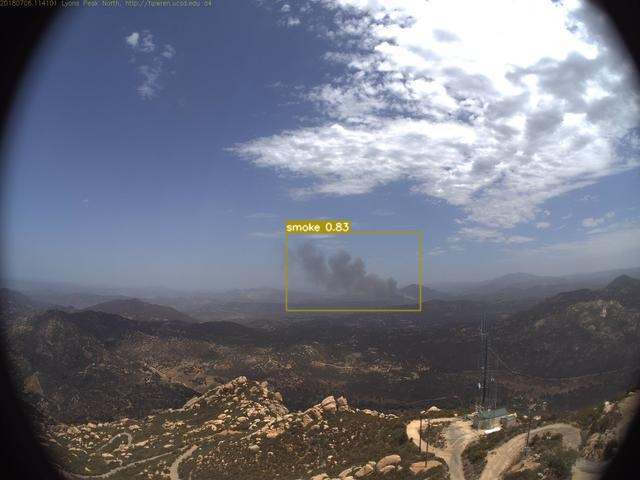

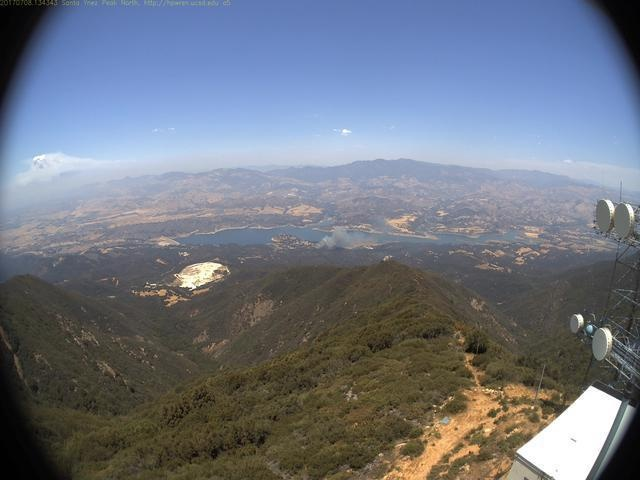

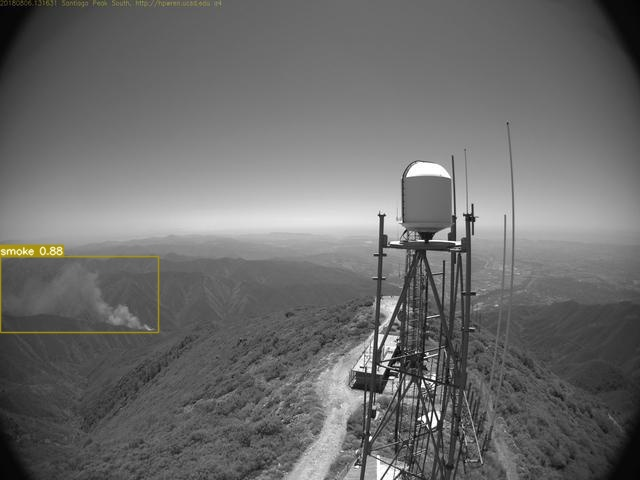

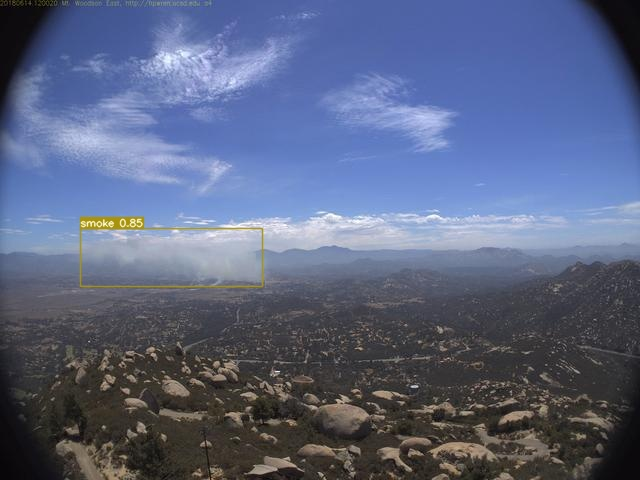

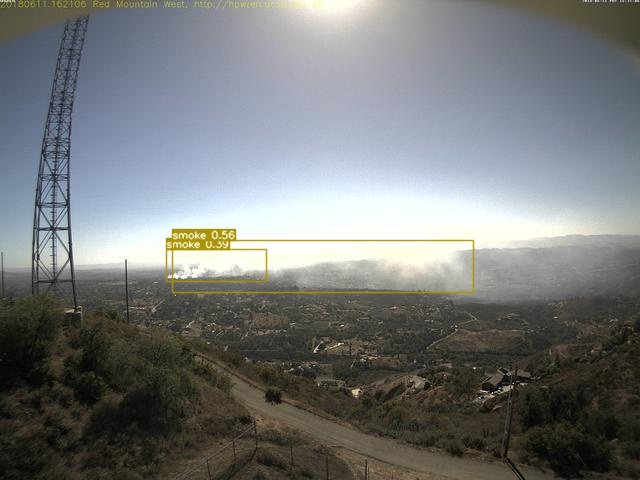

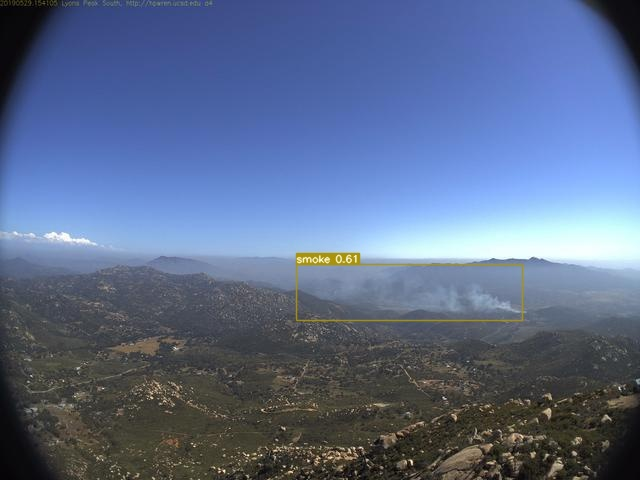

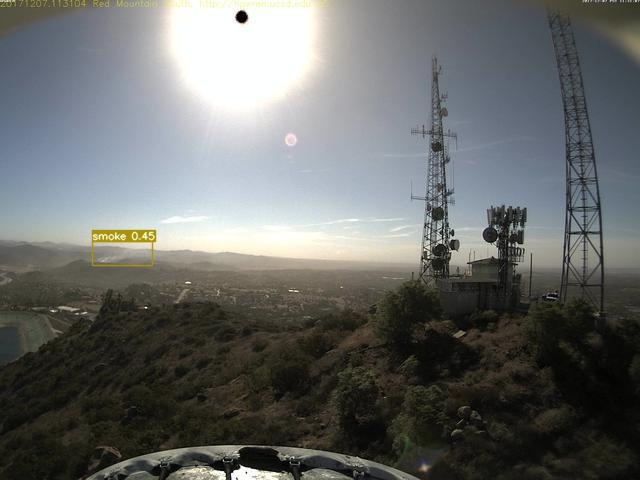

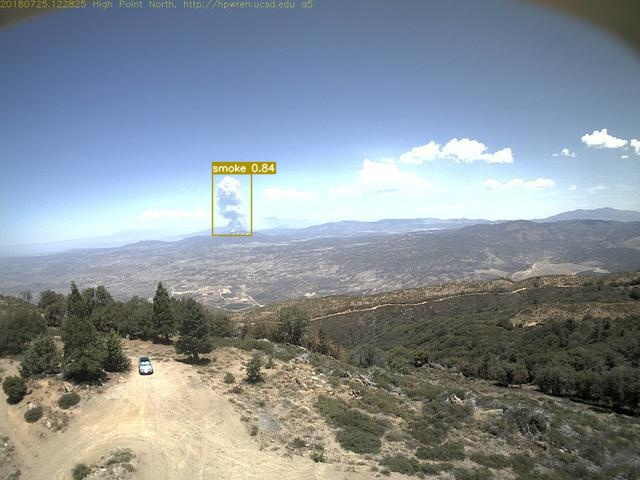

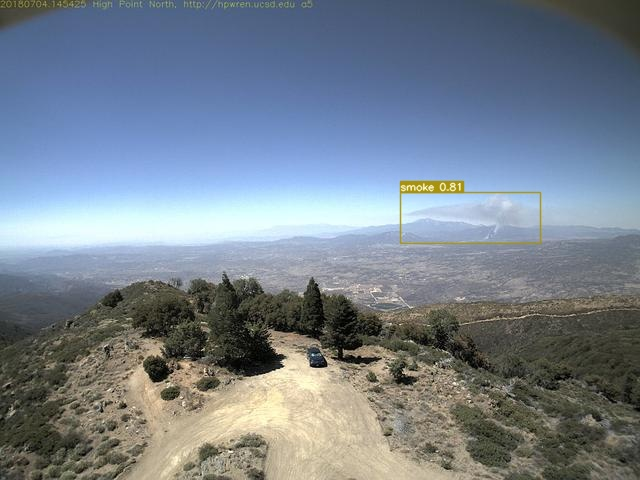

In [16]:
#Veamos los resultados
import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/yolov7/runs/detect/exp/*.jpg'): #Aquí asumimos que los ficheros son JPG y que solo hemos hecho una detección, si hemos hecho más: cambiar exp por exp2,exp3 o la última
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1
    